In [1]:
import pandas as pd
from clearml import Task
import numpy as np
import matplotlib.pyplot as plt
import gc

def download_and_process_tasks_batch(tag, experiment_name, batch_size=20):
    print(f"DOWNLOADING TASKS FOR {experiment_name}: {tag}")
    tasks = Task.get_tasks(project_name="oho", tags=[tag], allow_archived=False)
    print(f"Found {len(tasks)} tasks (excluding archived)")
    
    all_dfs = []
    for batch_start in range(0, len(tasks), batch_size):
        batch_end = min(batch_start + batch_size, len(tasks))
        batch_tasks = tasks[batch_start:batch_end]
        print(f"Processing batch {batch_start + 1}-{batch_end}/{len(tasks)}")
        
        data_rows = []
        for task in batch_tasks:
            base_task_data = {"task_id": task.id, "task_name": task.name}
            
            # Get config
            params = task.get_parameters() or {}
            for key, value in params.items():
                if any(x in key for x in ["learning_rate", "optimizer/_type", "seed/global_seed"]):
                    base_task_data[key] = value
            
            # Get metrics
            reported_scalars = task.get_reported_scalars()
            has_time_series = False
            
            for metric_name in ["test/loss", "train/learning_rate"]:
                if metric_name in reported_scalars:
                    variants = reported_scalars[metric_name]
                    for variant, data in variants.items():
                        if data["x"] and data["y"]:
                            for iteration, value in zip(data["x"], data["y"]):
                                if isinstance(value, (int, float)):
                                    row = base_task_data.copy()
                                    row["iteration"] = iteration
                                    row[f"metric/{metric_name}/{variant}"] = value
                                    data_rows.append(row)
                                    has_time_series = True
            
            if not has_time_series:
                data_rows.append(base_task_data)
        
        if data_rows:
            all_dfs.append(pd.DataFrame(data_rows))
        gc.collect()
    
    df = pd.concat(all_dfs, ignore_index=True) if all_dfs else pd.DataFrame()
    print(f"DataFrame created: {df.shape}")
    return df

def plot_lr_and_test_loss_by_config(df, experiment_name):
    """Plot learning rate and test loss curves for each LR pair configuration"""
    
    # Check if dual optimizer experiment
    lr0_col = "config/learners/0/optimizer/learning_rate/value"
    lr1_col = "config/learners/1/optimizer/learning_rate/value"
    
    if lr0_col not in df.columns or lr1_col not in df.columns:
        print("Not a dual optimizer experiment")
        return
    
    # Get unique LR pairs
    lr_pairs = df[[lr0_col, lr1_col]].drop_duplicates().dropna()
    
    print(f"Found {len(lr_pairs)} unique LR pair configurations")
    
    # Get metric columns
    lr_metric_cols = [col for col in df.columns if "train/learning_rate" in col]
    test_loss_cols = [col for col in df.columns if "test/loss" in col and "final_test" not in col]
    
    if not lr_metric_cols:
        print("No learning rate metric columns found")
        return
    if not test_loss_cols:
        print("No test loss metric columns found")
        return
    
    lr_col = lr_metric_cols[0]
    test_loss_col = test_loss_cols[0]
    
    # For each LR pair, create plots
    for idx, (_, row) in enumerate(lr_pairs.iterrows()):
        lr0, lr1 = row[lr0_col], row[lr1_col]
        
        # Filter data for this LR pair
        config_data = df[
            (df[lr0_col] == lr0) & 
            (df[lr1_col] == lr1)
        ]
        
        # Get learning rate data
        lr_data = config_data[config_data[lr_col].notna()]
        # Get test loss data
        test_loss_data = config_data[config_data[test_loss_col].notna()]
        
        if lr_data.empty and test_loss_data.empty:
            continue
        
        print(f"\nPlotting LR pair {idx+1}/{len(lr_pairs)}: LR0={float(lr0):.6f}, LR1={float(lr1):.6f}")
        
        # Create two subplots
        fig, axes = plt.subplots(1, 2, figsize=(16, 6))
        
        # Plot 1: Learning Rate Evolution
        if not lr_data.empty:
            seeds = lr_data["config/seed/global_seed"].dropna().unique()
            for seed in seeds:
                seed_data = lr_data[lr_data["config/seed/global_seed"] == seed].sort_values('iteration')
                if len(seed_data) > 0:
                    axes[0].plot(seed_data["iteration"].values, seed_data[lr_col].values, 
                               alpha=0.7, linewidth=1.5, label=f'Seed {int(seed)}')
            
            axes[0].set_xlabel('Iteration')
            axes[0].set_ylabel('Learning Rate')
            axes[0].set_title(f'{experiment_name}: Learning Rate Evolution\nLR0={float(lr0):.6f}, LR1={float(lr1):.6f}')
            axes[0].legend(fontsize=8)
            axes[0].grid(True, alpha=0.3)
            axes[0].set_yscale('log')
        else:
            axes[0].text(0.5, 0.5, "No LR data", ha="center", va="center", transform=axes[0].transAxes)
        
        # Plot 2: Test Loss Evolution
        if not test_loss_data.empty:
            # Filter out invalid test losses
            valid_test_data = test_loss_data[
                (test_loss_data[test_loss_col] > 0) &
                (test_loss_data[test_loss_col] != -1) &
                np.isfinite(test_loss_data[test_loss_col])
            ]
            
            seeds = valid_test_data["config/seed/global_seed"].dropna().unique()
            for seed in seeds:
                seed_data = valid_test_data[valid_test_data["config/seed/global_seed"] == seed].sort_values('iteration')
                if len(seed_data) > 0:
                    axes[1].plot(seed_data["iteration"].values, seed_data[test_loss_col].values, 
                               alpha=0.7, linewidth=1.5, label=f'Seed {int(seed)}')
            
            axes[1].set_xlabel('Iteration')
            axes[1].set_ylabel('Test Loss')
            axes[1].set_title(f'{experiment_name}: Test Loss Evolution\nLR0={float(lr0):.6f}, LR1={float(lr1):.6f}')
            axes[1].legend(fontsize=8)
            axes[1].grid(True, alpha=0.3)
        else:
            axes[1].text(0.5, 0.5, "No test loss data", ha="center", va="center", transform=axes[1].transAxes)
        
        plt.tight_layout()
        plt.show()



In [2]:
# Usage:
df_exp2 = download_and_process_tasks_batch("opt: 8fbe85a7bebe4c809f768ca84d0c1aca", "EXPERIMENT 2")


DOWNLOADING TASKS FOR EXPERIMENT 2: opt: 8fbe85a7bebe4c809f768ca84d0c1aca
Found 480 tasks (excluding archived)
Processing batch 1-20/480
Processing batch 21-40/480
Processing batch 41-60/480
Processing batch 61-80/480
Processing batch 81-100/480
Processing batch 101-120/480
Processing batch 121-140/480
Processing batch 141-160/480
Processing batch 161-180/480
Processing batch 181-200/480
Processing batch 201-220/480
Processing batch 221-240/480
Processing batch 241-260/480
Processing batch 261-280/480
Processing batch 281-300/480
Processing batch 301-320/480
Processing batch 321-340/480
Processing batch 341-360/480
Processing batch 361-380/480
Processing batch 381-400/480
Processing batch 401-420/480
Processing batch 421-440/480
Processing batch 441-460/480
Processing batch 461-480/480
DataFrame created: (1920960, 14)


Found 24 unique LR pair configurations

Plotting LR pair 1/24: LR0=0.000100, LR1=0.000100


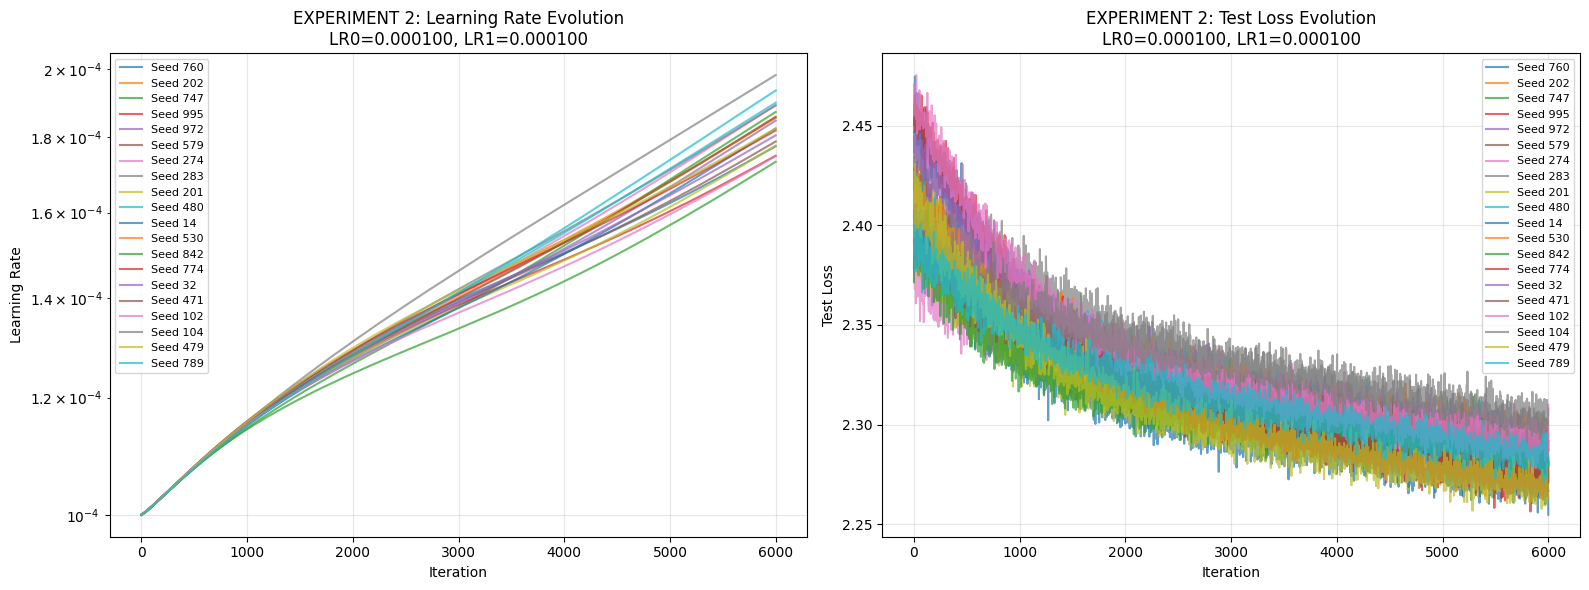


Plotting LR pair 2/24: LR0=0.001357, LR1=0.000100


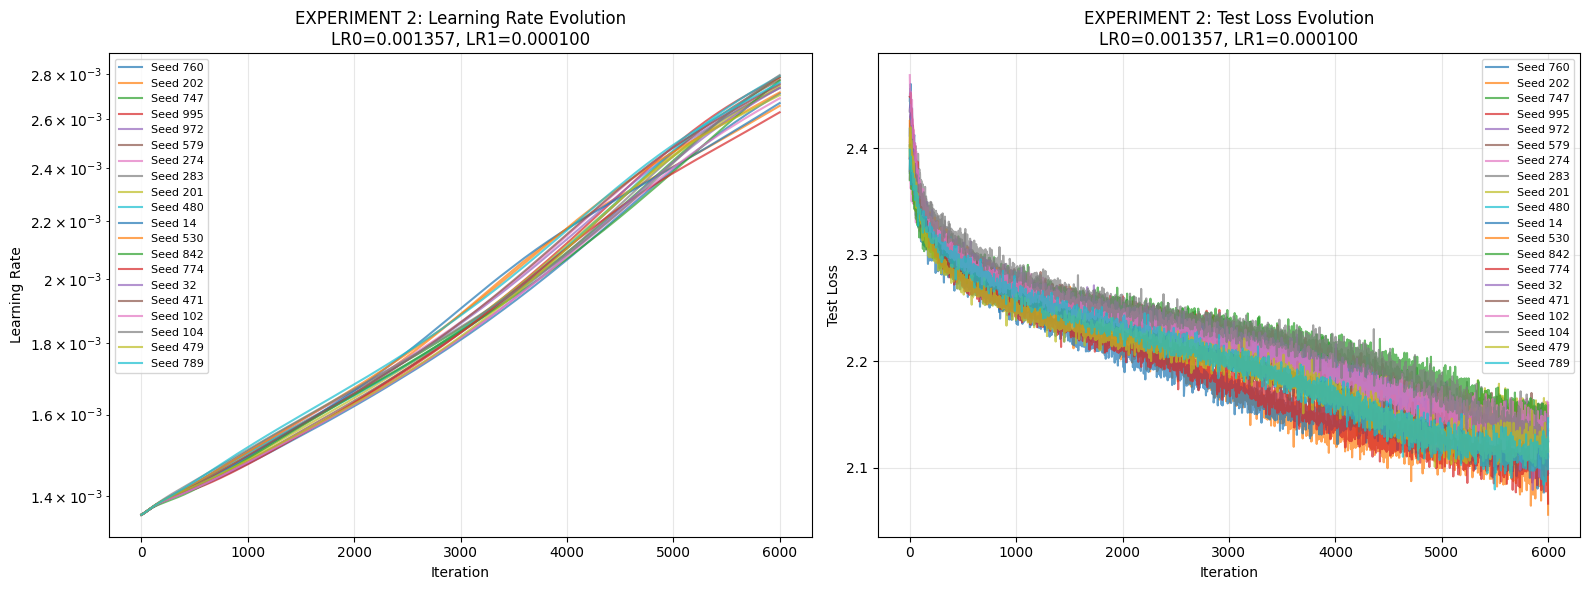


Plotting LR pair 3/24: LR0=0.018420, LR1=0.000100


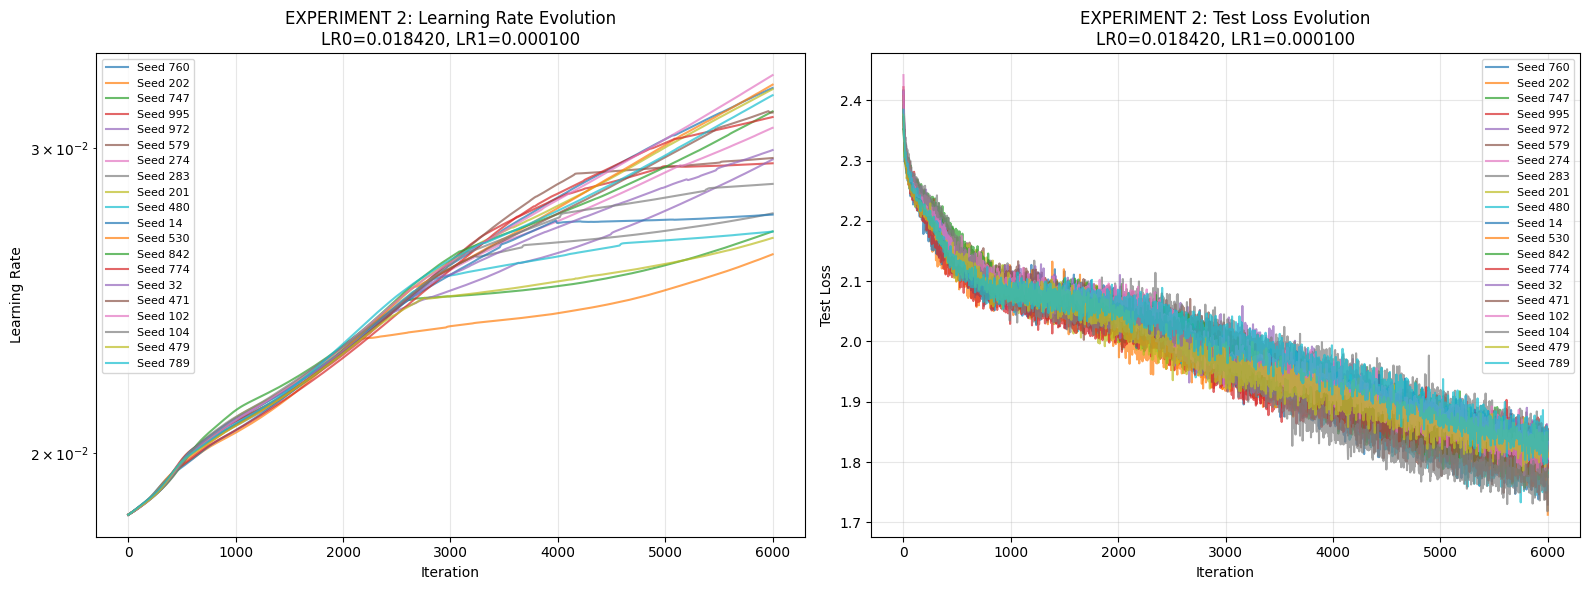


Plotting LR pair 4/24: LR0=0.250000, LR1=0.000100


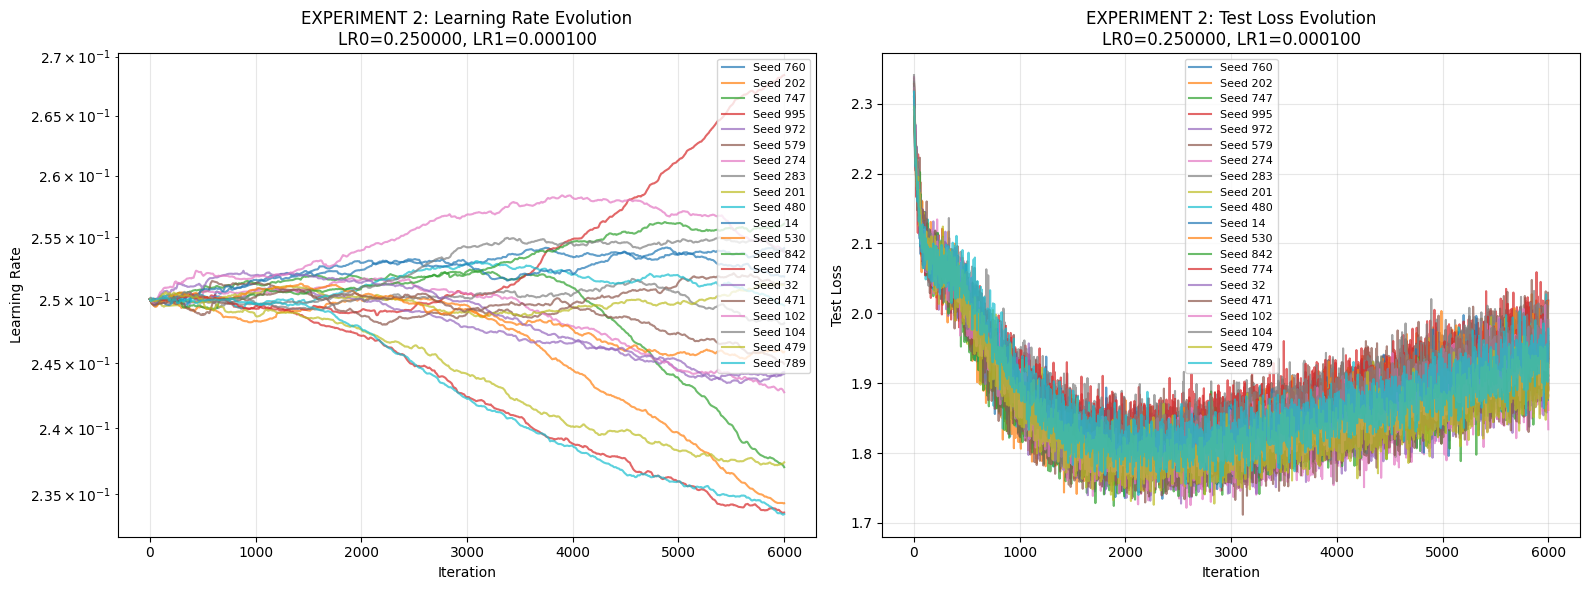


Plotting LR pair 5/24: LR0=0.000100, LR1=0.000251


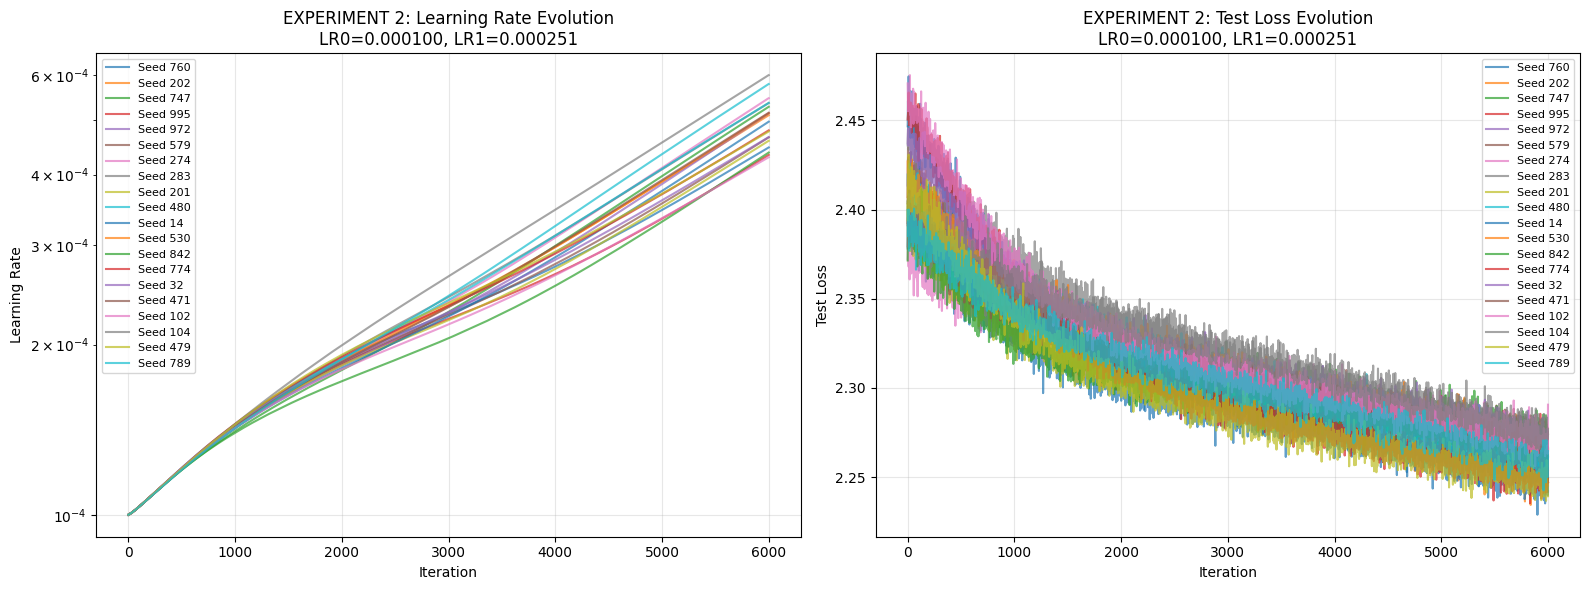


Plotting LR pair 6/24: LR0=0.001357, LR1=0.000251


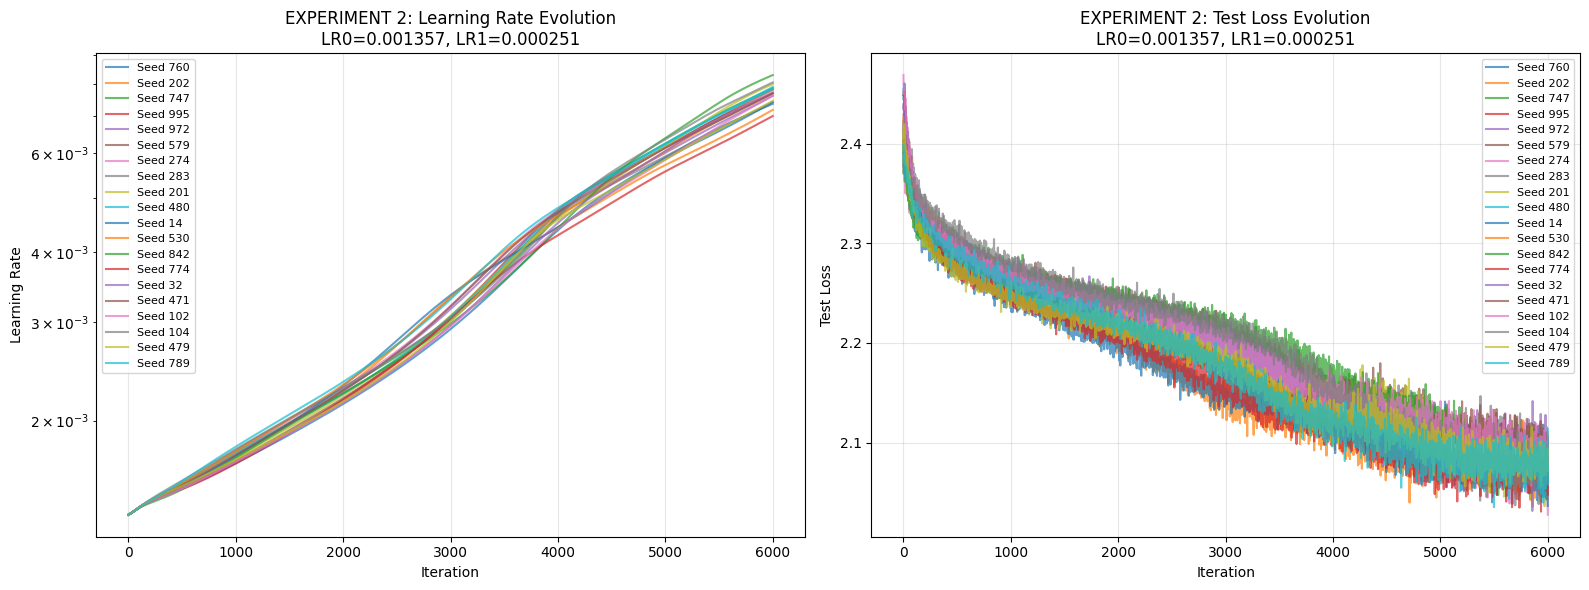


Plotting LR pair 7/24: LR0=0.018420, LR1=0.000251


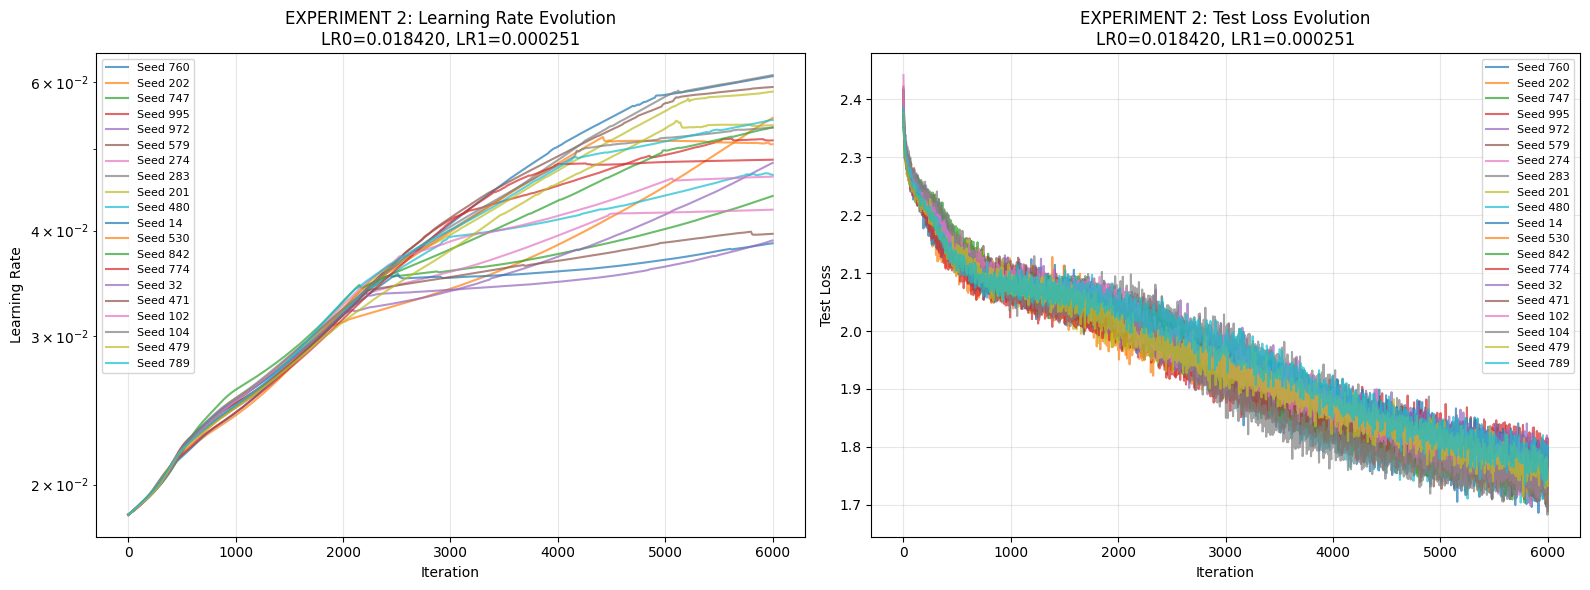


Plotting LR pair 8/24: LR0=0.250000, LR1=0.000251


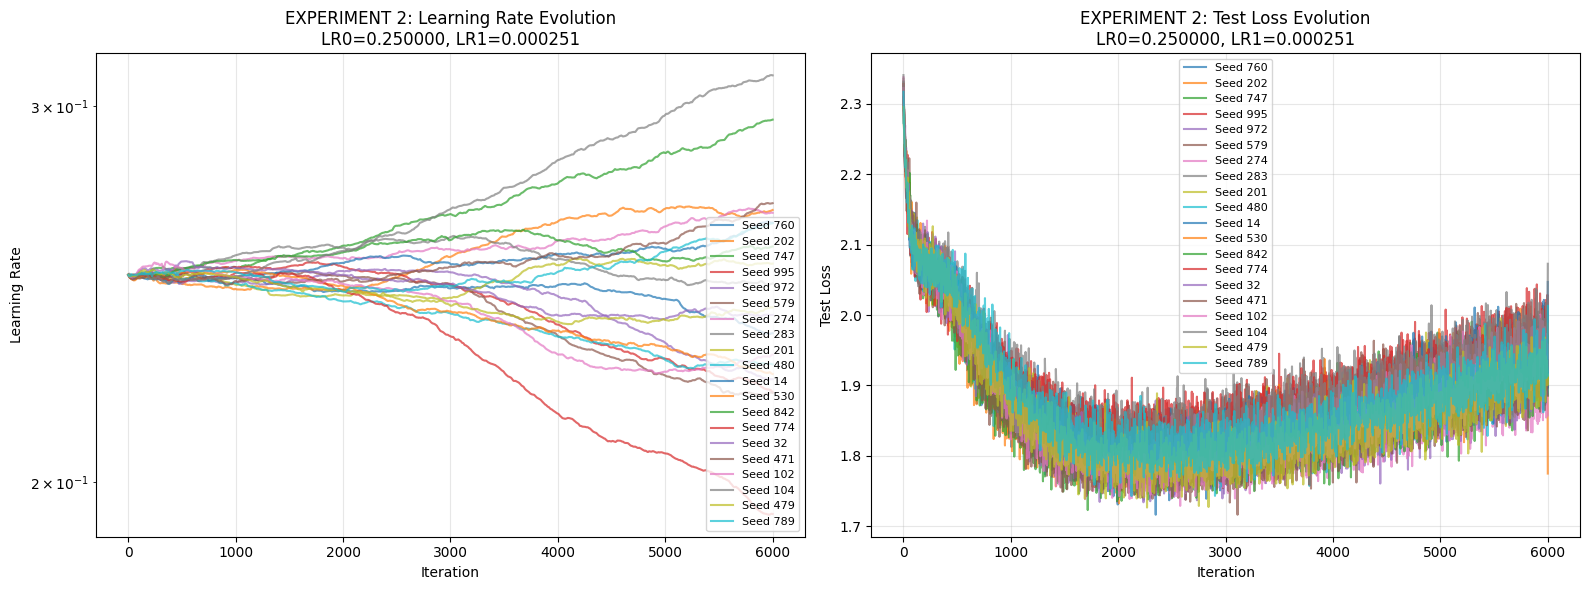


Plotting LR pair 9/24: LR0=0.000100, LR1=0.000631


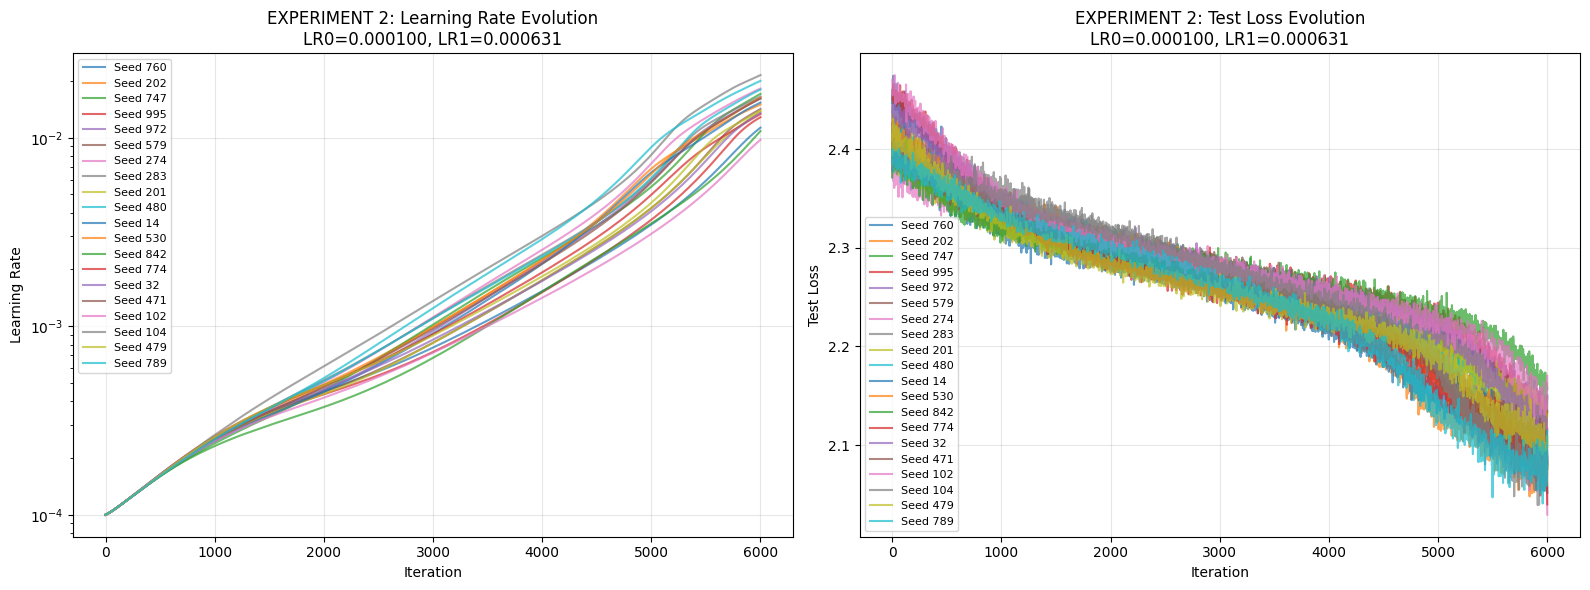


Plotting LR pair 10/24: LR0=0.001357, LR1=0.000631


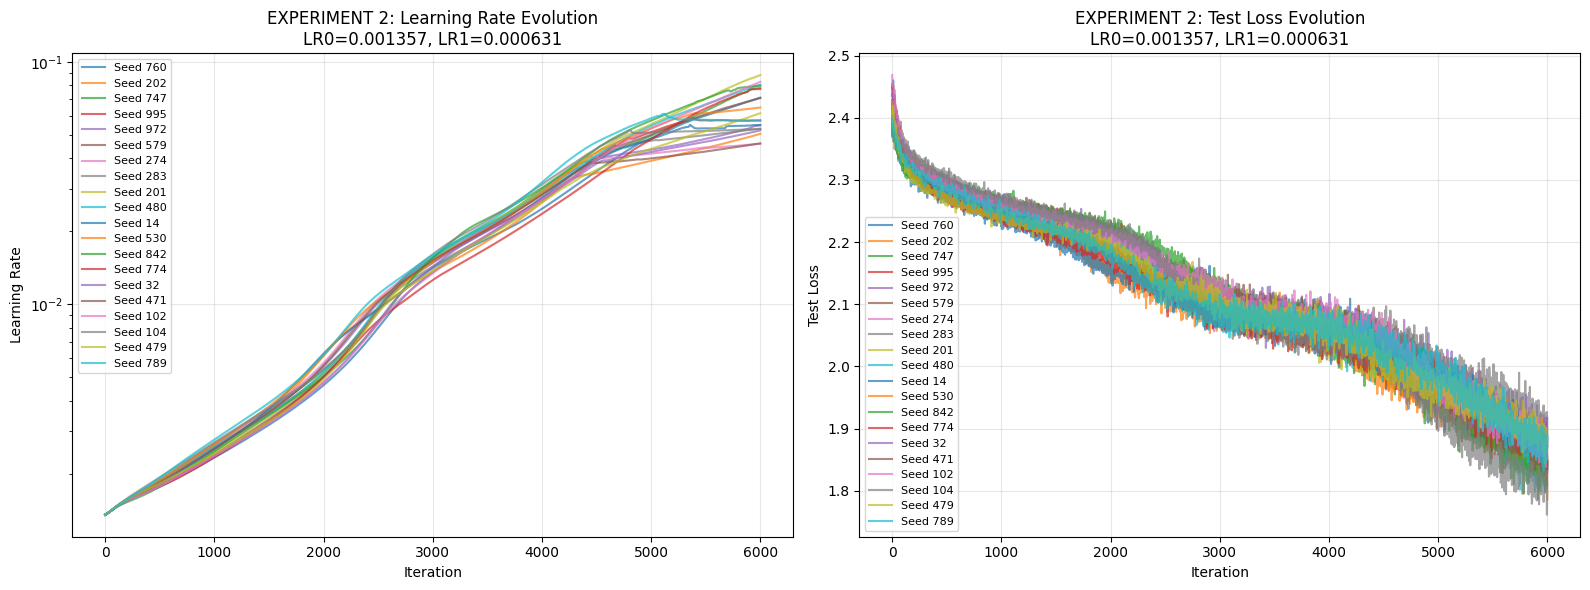


Plotting LR pair 11/24: LR0=0.018420, LR1=0.000631


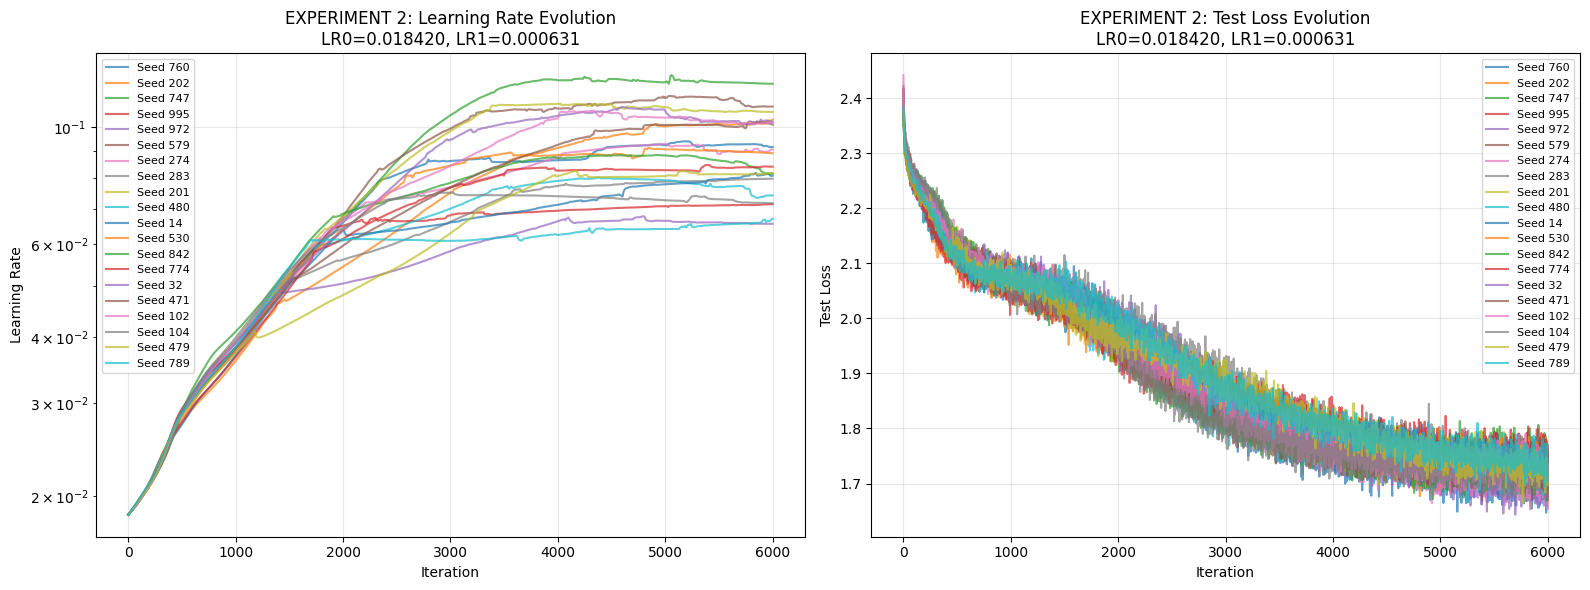


Plotting LR pair 12/24: LR0=0.250000, LR1=0.000631


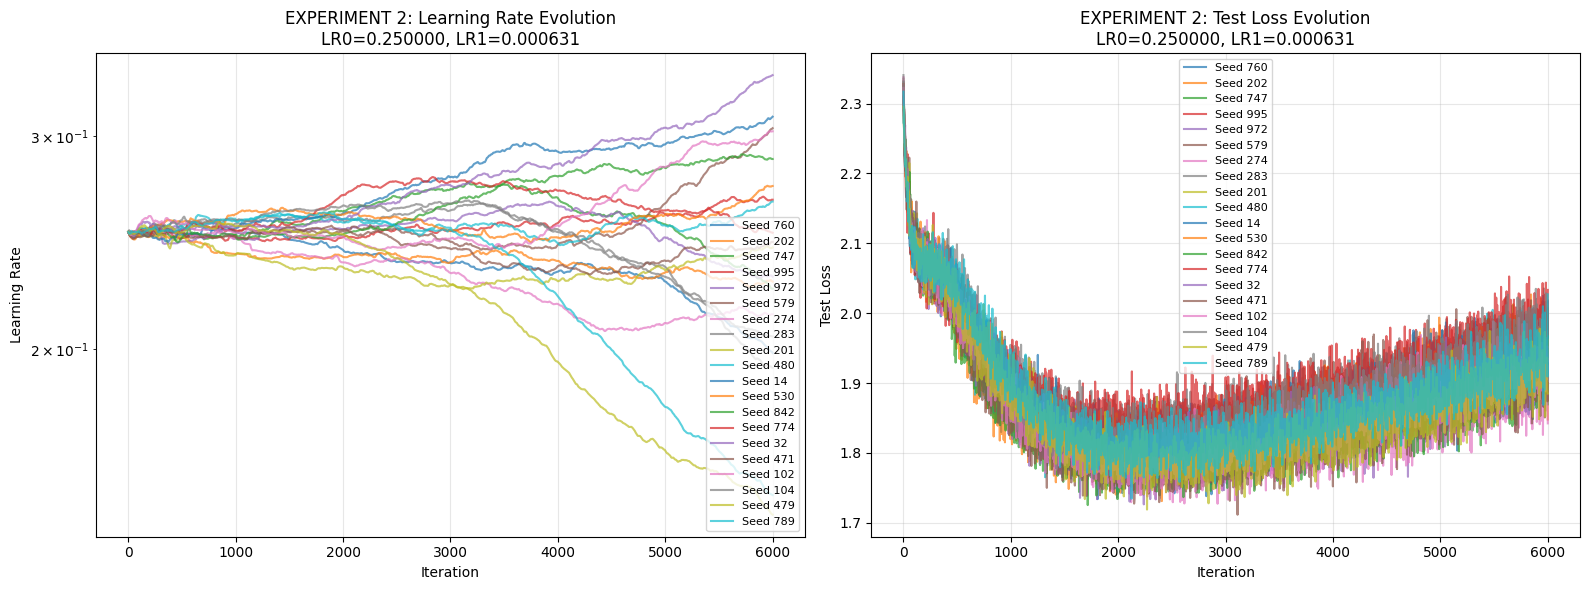


Plotting LR pair 13/24: LR0=0.000100, LR1=0.001585


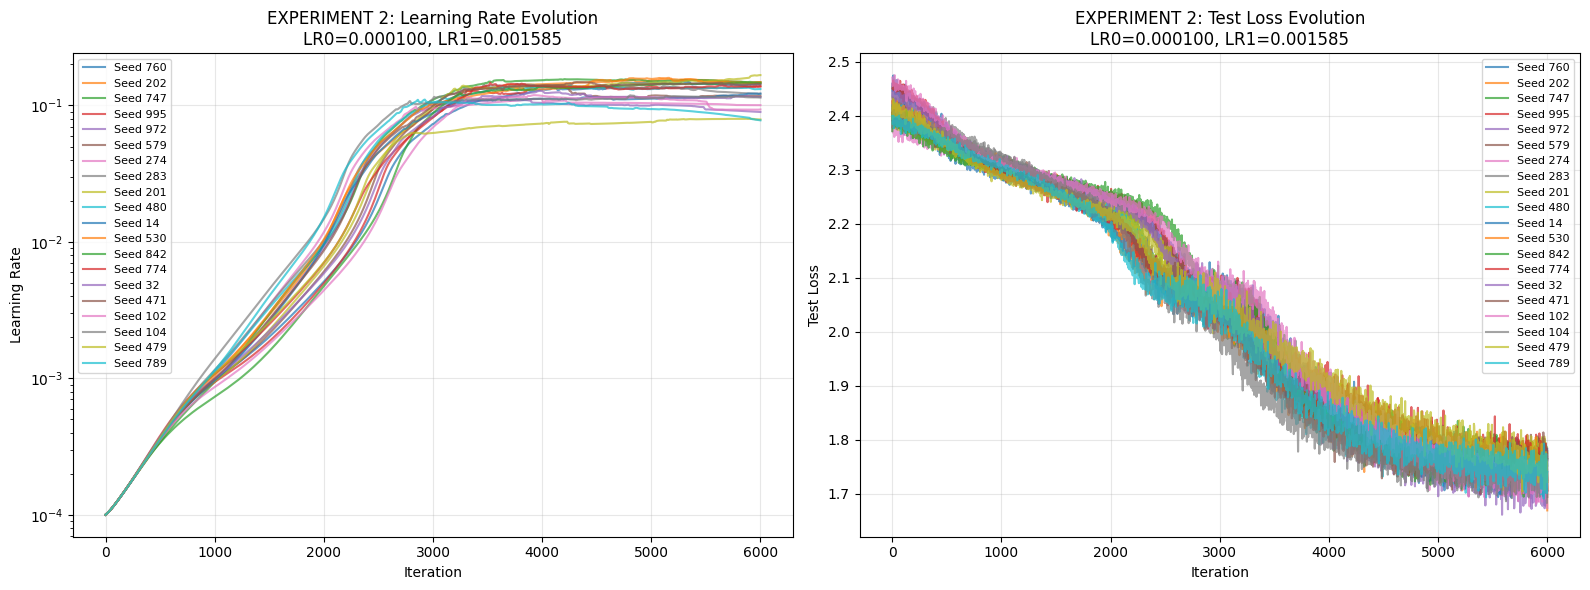


Plotting LR pair 14/24: LR0=0.001357, LR1=0.001585


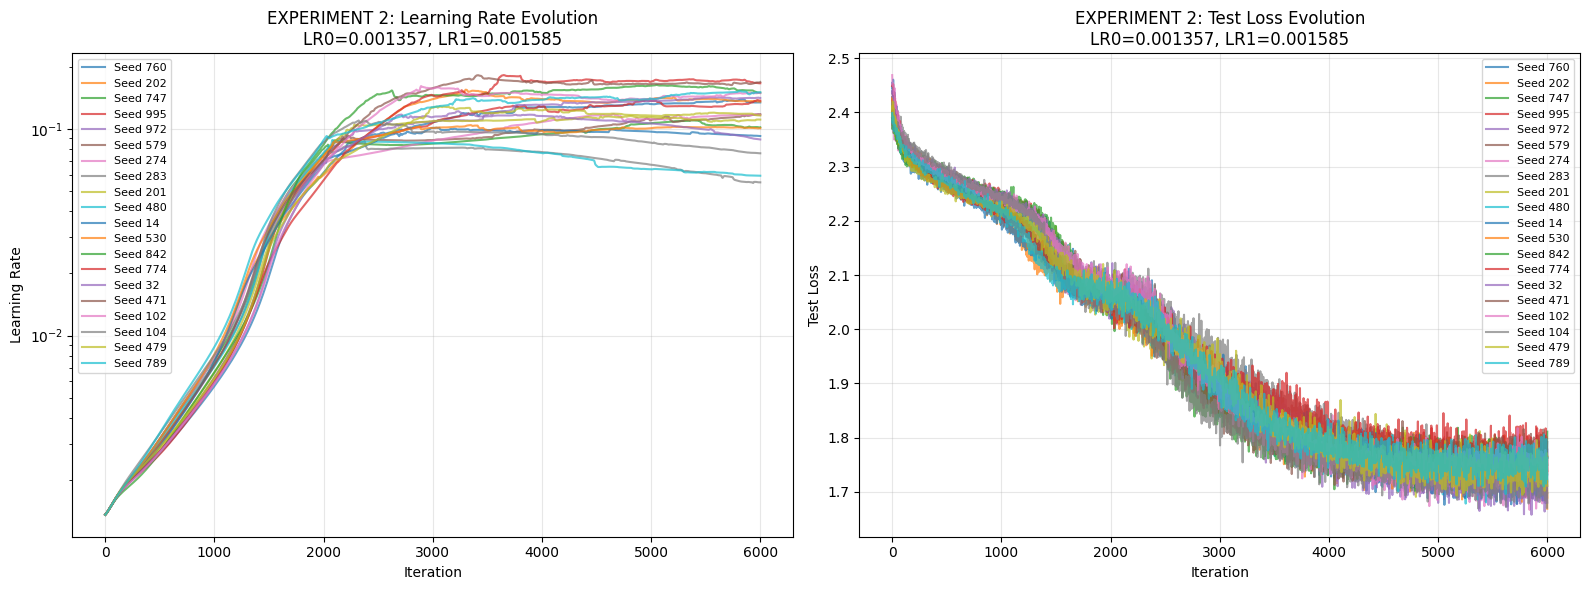


Plotting LR pair 15/24: LR0=0.018420, LR1=0.001585


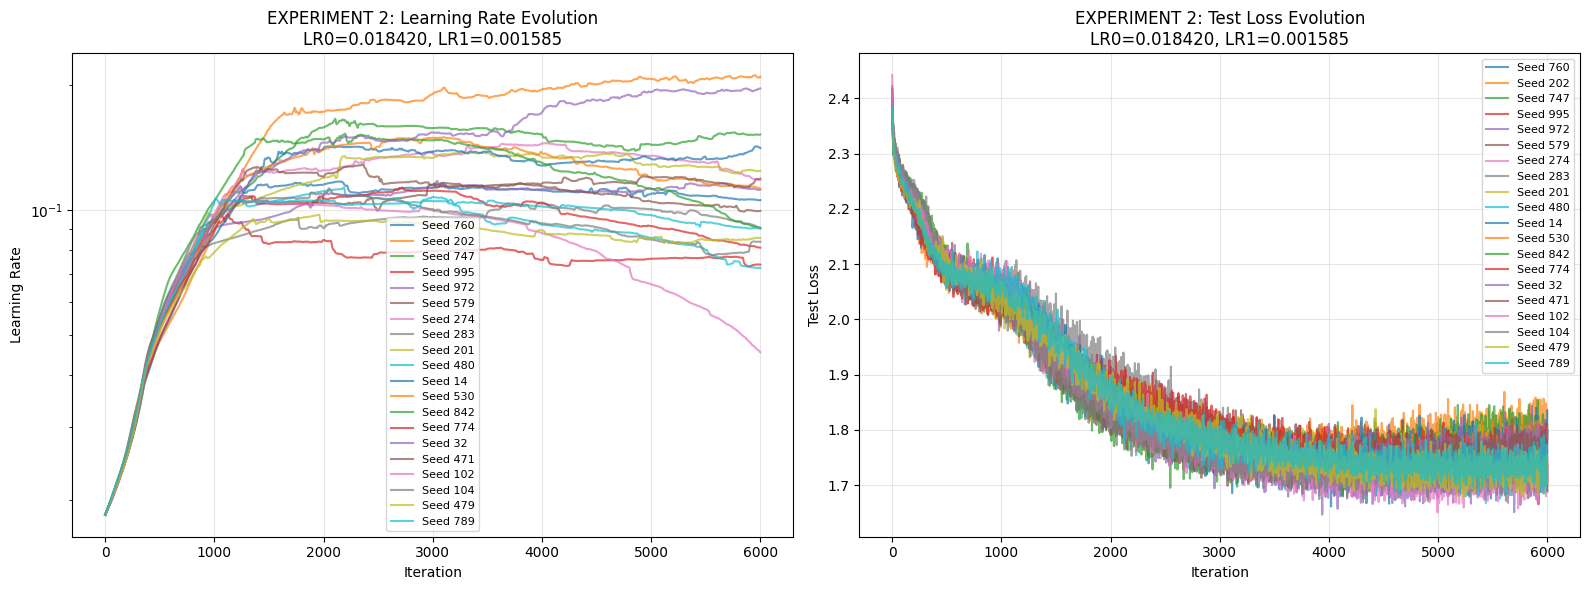


Plotting LR pair 16/24: LR0=0.250000, LR1=0.001585


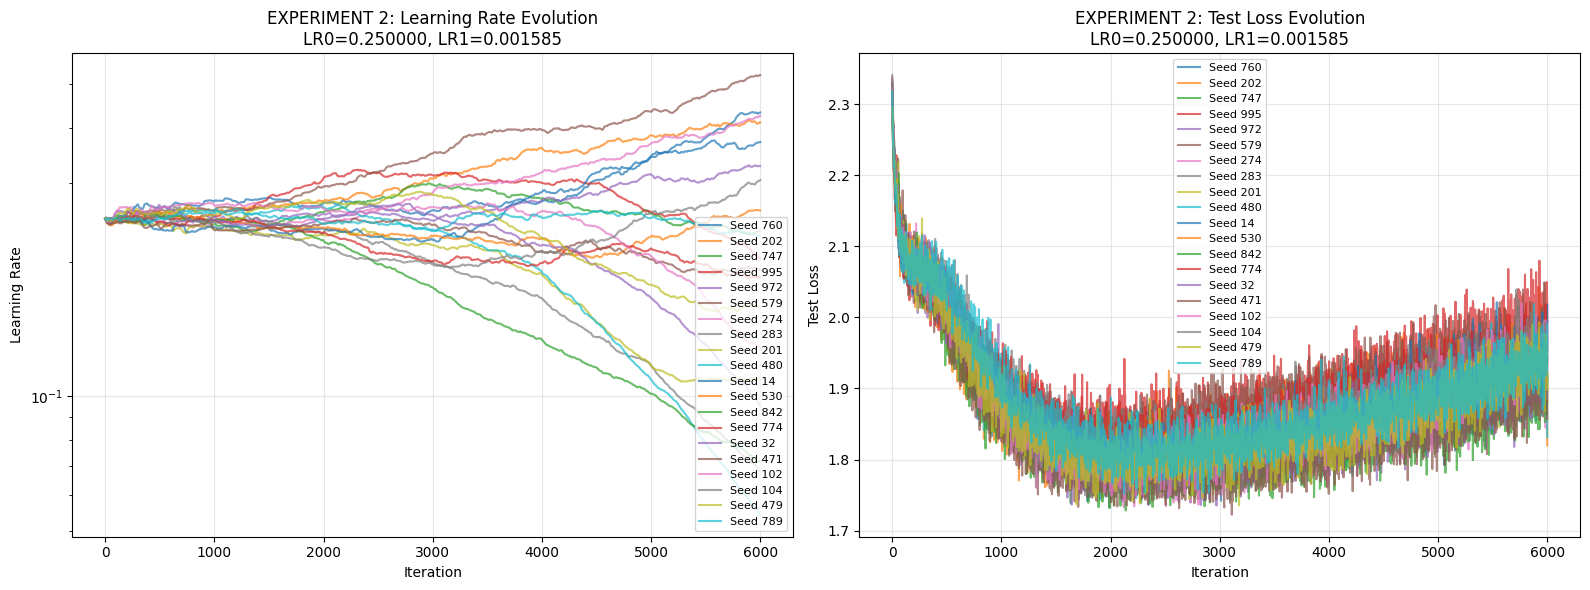


Plotting LR pair 17/24: LR0=0.000100, LR1=0.003981


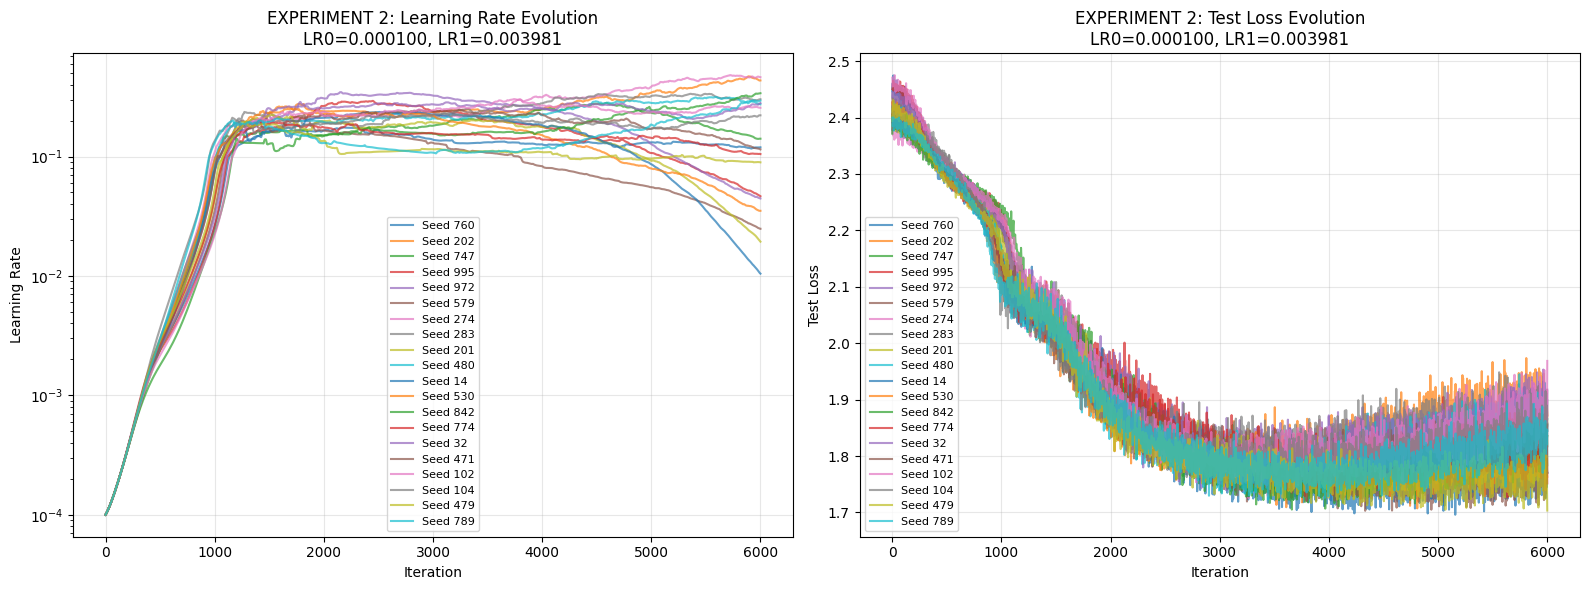


Plotting LR pair 18/24: LR0=0.001357, LR1=0.003981


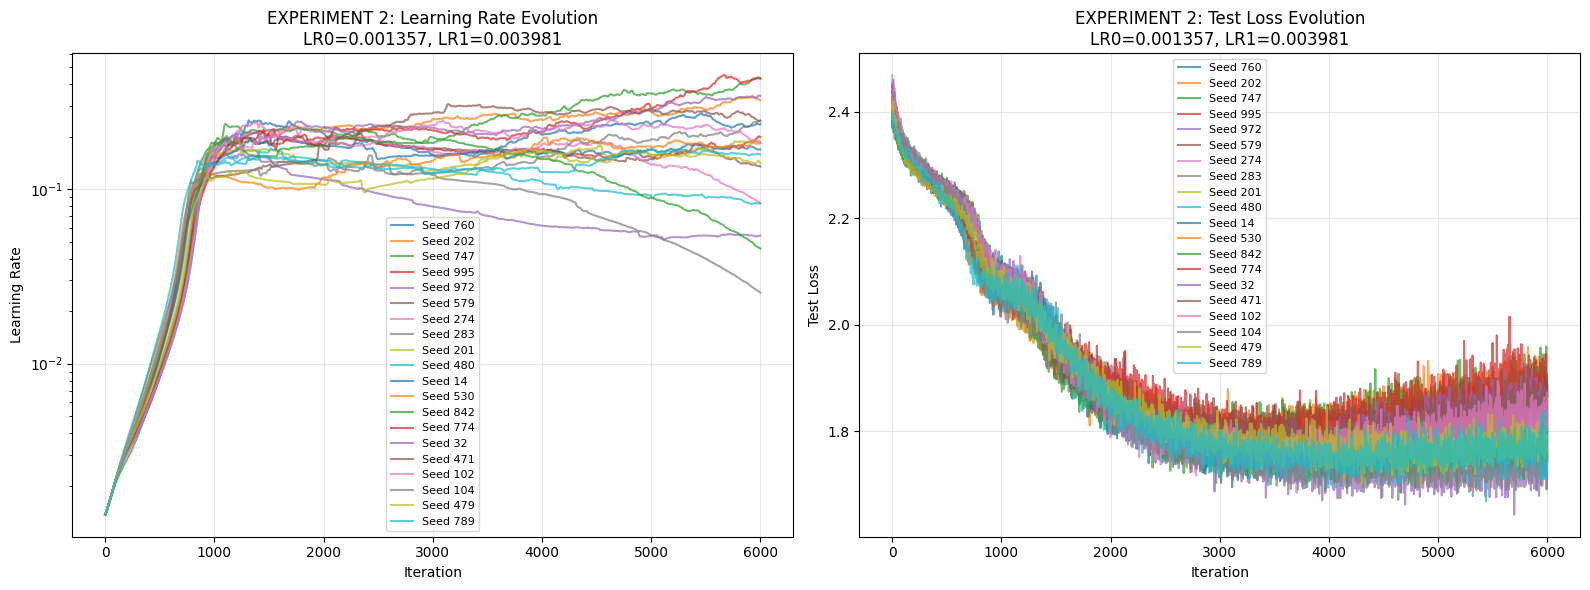


Plotting LR pair 19/24: LR0=0.018420, LR1=0.003981


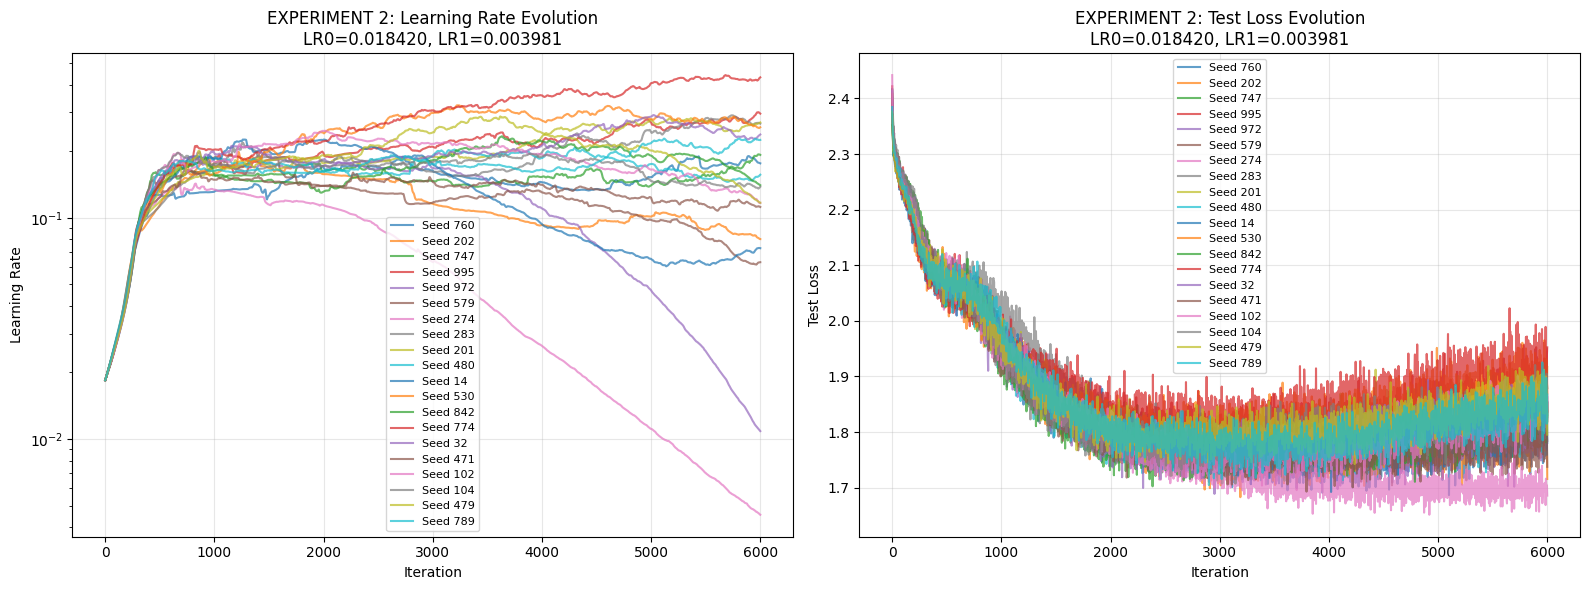


Plotting LR pair 20/24: LR0=0.250000, LR1=0.003981


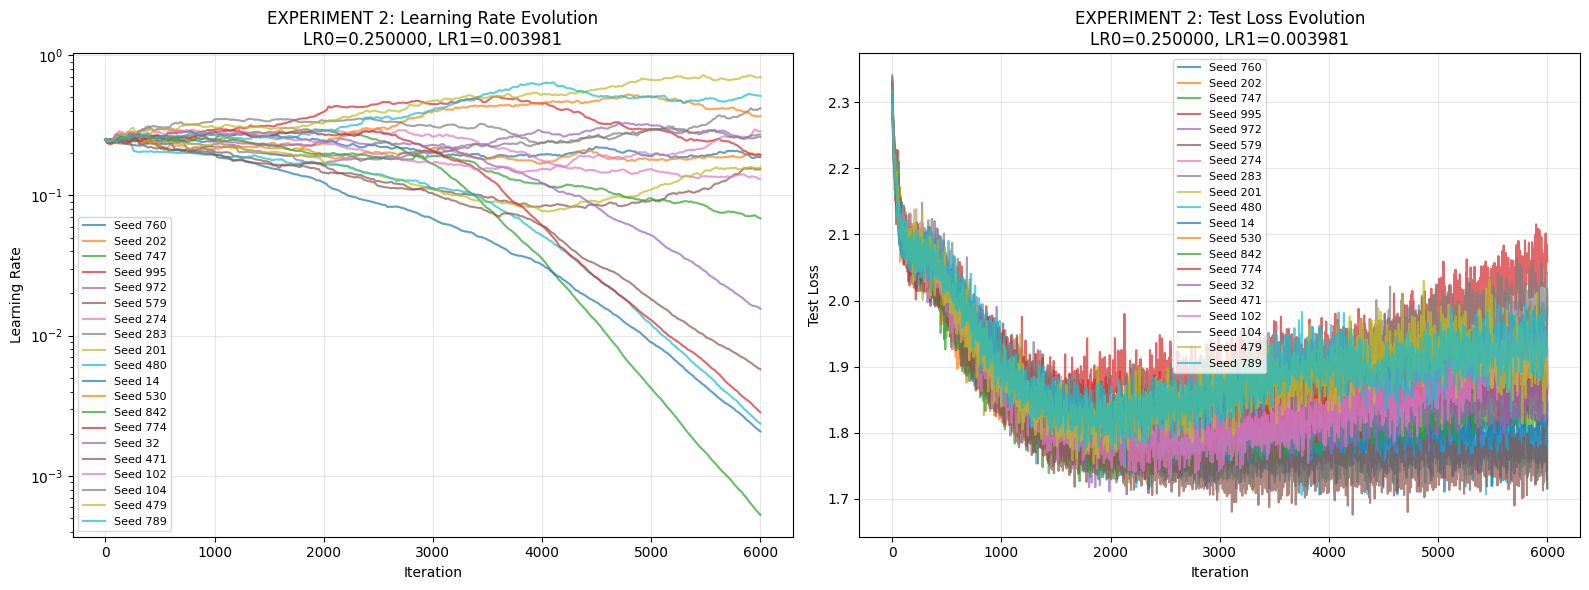


Plotting LR pair 21/24: LR0=0.000100, LR1=0.010000


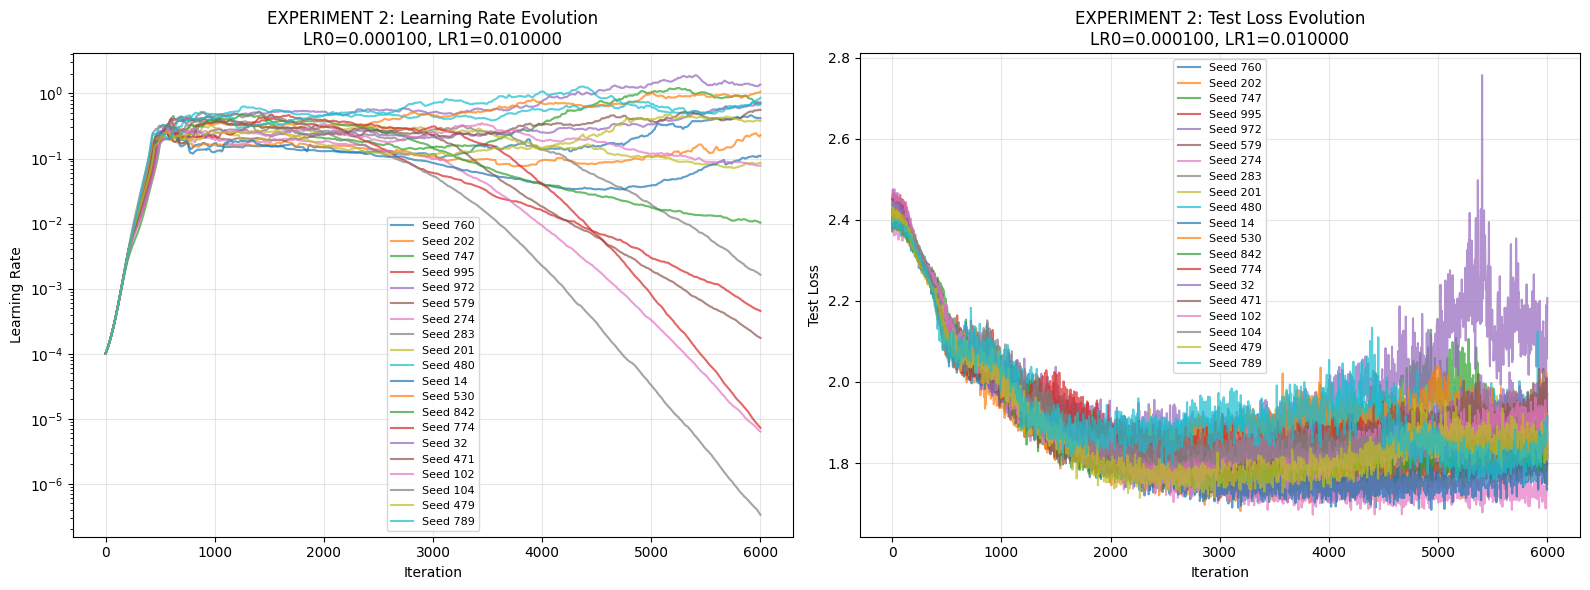


Plotting LR pair 22/24: LR0=0.001357, LR1=0.010000


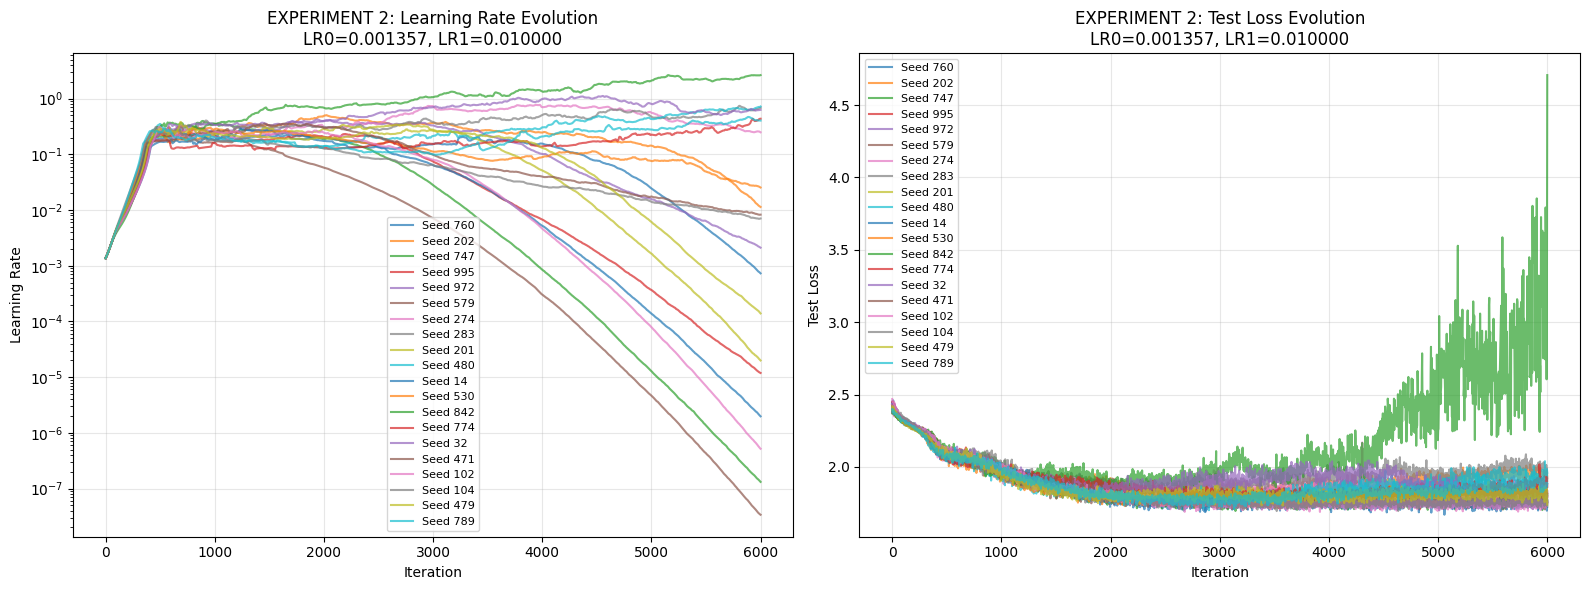


Plotting LR pair 23/24: LR0=0.018420, LR1=0.010000


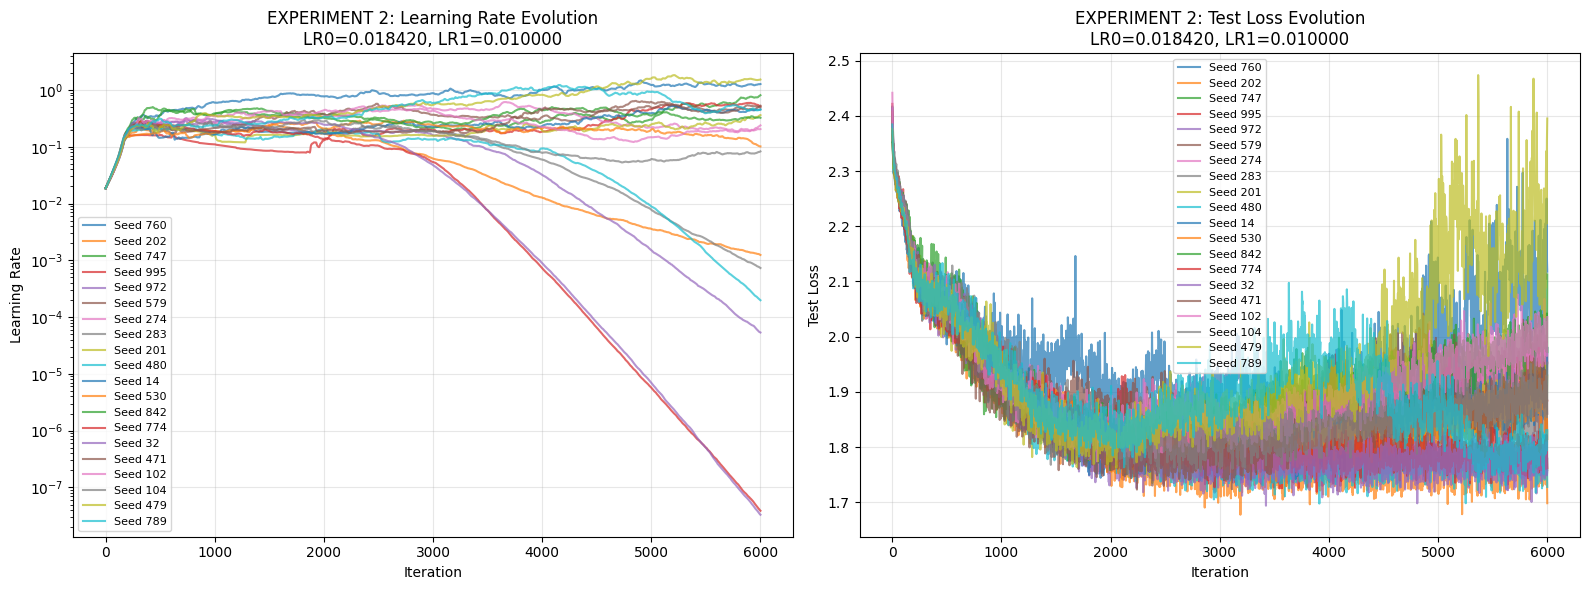


Plotting LR pair 24/24: LR0=0.250000, LR1=0.010000


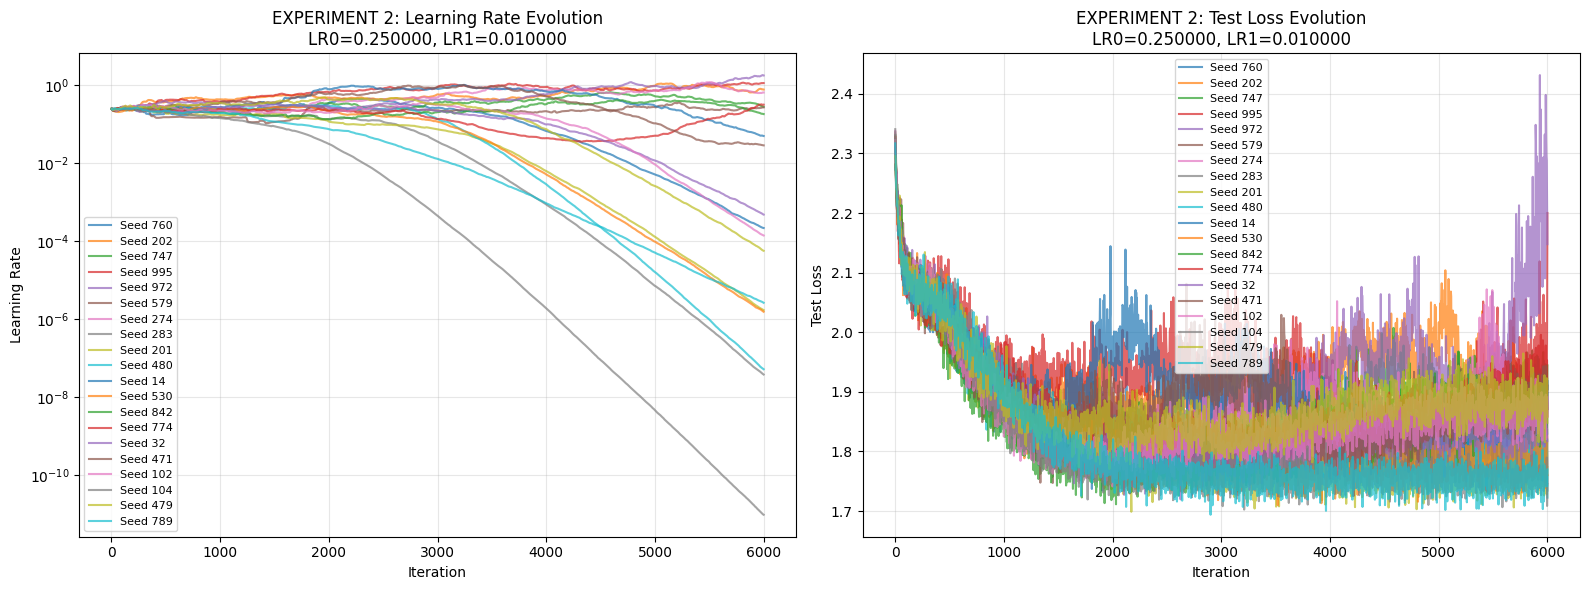

In [3]:
plot_lr_and_test_loss_by_config(df_exp2, "EXPERIMENT 2")